In [1]:
import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
# from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
# import tensorflow_hub as hub


2.3.0


In [2]:
params = {
    'image_size': [225, 225],
    'text_input': (58,),
    'batch_size': 128,
    'vocab_size': 30000,
    'examples_per_file': 850, #will not change
}

In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

    client = storage.Client(project='hateful-memes', credentials=credentials)

In [4]:
num_examples_per_tfrecordfile = params['examples_per_file'] # 850 #this will not change

In [5]:
bucket = 'jh_hateful_memes'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [6]:
# tfrecords

In [7]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [8]:
def decode_example(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'label': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 255.0
    label = single_example['label']
    return text, image, label

def no_tpu_output(text, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, image), label
    
    

In [9]:
def create_train_ds(files, batch_size=params['batch_size'], tpu=tpu, file_size=num_examples_per_tfrecordfile):
    '''
    function to create dataset for training/validation
    
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        batch_size: int, batch size of training/validation step
        tpu: bool, default 'tpu' global variable, True is TPU is being used - not a bool update
        file_size: int, default num_examples_per_tfrecordfile variable,
            number of examples in each TFrecord file
    ***todo - update batch_size and file_size to params
    returns:
        ds: tensorflow input pipeline with images, text and labels
            if tpu is not None, output of ds is: text, image, label
            if tpu is None, output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
    ds = tf.data.TFRecordDataset(filenames = tfrecords)
    ds = ds.map(decode_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #consider adding augmentation to image - can't flip(?)
    if tpu is None:
        ds = ds.map(no_tpu_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
#     ds = ds.cache() # -- confirm if dataset is small enough to be cached
    
    ds_batches = (len(files) * file_size) // batch_size
    return ds, ds_batches
    
    

In [10]:
def create_model(params=params):
    '''
    creates model with two inputs and out output
    '''
    text_input_shape = params['text_input']
    vocab_size = params['vocab_size']
    image_size = params['image_size']
    input_text = layers.Input(text_input_shape, name='text_input')
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=64, 
                                 input_length=58, mask_zero=True)(input_text)
    x_text = embedding
    #clean up the code 
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.MaxPooling1D(4, padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.SeparableConv1D(filters=64, kernel_size=4, activation='relu', padding='same')(x_text)
    x_text = layers.MaxPooling1D(4, padding='same')(x_text)
    x_text = layers.Flatten()(x_text)
    output_layer_text = layers.Dense(1000, activation='sigmoid', name='text_output')(x_text)
    
    input_image = layers.Input((*image_size, 3), name='image_input')#todo -make the 225 call a variable
    x_img = input_image
    x_img = layers.Conv2D(filters=64, kernel_size=5, padding='same')(x_img)
    x_img = layers.MaxPooling2D(2, 2)(x_img)
    x_img = layers.BatchNormalization()(x_img)
    x_img = layers.ReLU()(x_img)
    x_img = layers.Dense(16, activation='tanh')(x_img)
    x_img = layers.Conv2D(filters=128, kernel_size=5, padding='same')(x_img)
    x_img = layers.MaxPooling2D(2, 2)(x_img)
    x_img = layers.BatchNormalization()(x_img)
    x_img = layers.ReLU()(x_img)
    x_img = layers.Dense(16, activation='tanh')(x_img)
    x_img = layers.Flatten()(x_img)
    output_layer_image = layers.Dense(1000, activation='sigmoid', name='image_out')(x_img)
    
    x = layers.Concatenate()([output_layer_text, output_layer_image])
    final_output = layers.Dense(1, activation='sigmoid', name='final_out')(x)
    
    model = keras.Model([input_text, input_image], final_output)
    metrics = [
          keras.metrics.TruePositives(name='tp'),
    #           keras.metrics.FalsePositives(name='fp'),
    #           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
    #           keras.metrics.Precision(name='precision'),
    #           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics)
    
    return model
    
    

In [11]:
train_files, valid_files = train_test_split(tfrecords,
                              test_size=.2, random_state=1)


In [12]:
train_ds, train_steps = create_train_ds(train_files)
valid_ds, valid_steps = create_train_ds(valid_files)

In [13]:
with strategy.scope():
    model = create_model()

In [14]:
# model.summary()

In [15]:
#todo - consider using class weights
history = model.fit(train_ds, epochs=100,
                   callbacks=None, #todo - add early stopping
                   validation_data=valid_ds,
                   steps_per_epoch=train_steps,
                   validation_steps=valid_steps)

Epoch 1/100
53/53 [==============================] - 125s 2s/step - loss: 0.8846 - tp: 238.0000 - fn: 2216.0000 - accuracy: 0.6055 - auc: 0.5009 - val_loss: 0.7828 - val_tp: 595.0000 - val_fn: 16.0000 - val_accuracy: 0.3822 - val_auc: 0.5543
Epoch 2/100
53/53 [==============================] - 118s 2s/step - loss: 0.6575 - tp: 67.0000 - fn: 2359.0000 - accuracy: 0.6355 - auc: 0.5246 - val_loss: 0.6737 - val_tp: 324.0000 - val_fn: 287.0000 - val_accuracy: 0.6004 - val_auc: 0.6180
Epoch 3/100
53/53 [==============================] - 113s 2s/step - loss: 0.6481 - tp: 155.0000 - fn: 2256.0000 - accuracy: 0.6272 - auc: 0.5732 - val_loss: 0.6264 - val_tp: 108.0000 - val_fn: 503.0000 - val_accuracy: 0.6605 - val_auc: 0.6638
Epoch 4/100
53/53 [==============================] - 113s 2s/step - loss: 0.6336 - tp: 373.0000 - fn: 2091.0000 - accuracy: 0.6340 - auc: 0.6297 - val_loss: 0.6385 - val_tp: 38.0000 - val_fn: 573.0000 - val_accuracy: 0.6454 - val_auc: 0.6653
Epoch 5/100
53/53 [============

In [16]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

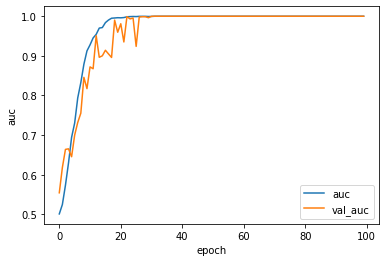

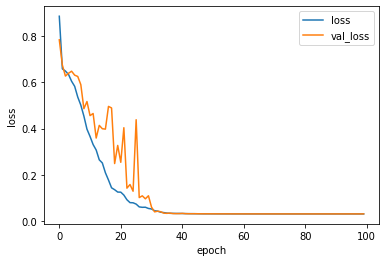

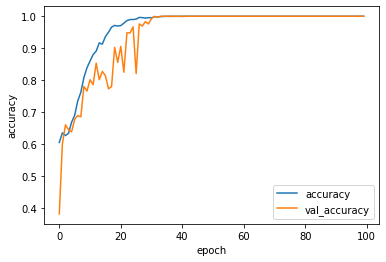

In [17]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [18]:
history.history

{'accuracy': [0.6055424809455872,
  0.6354658007621765,
  0.6272110939025879,
  0.6339917182922363,
  0.6689268946647644,
  0.6901533007621765,
  0.7354068160057068,
  0.7619398832321167,
  0.8085200190544128,
  0.8388856053352356,
  0.8596698045730591,
  0.880011796951294,
  0.8910672068595886,
  0.916568398475647,
  0.9128832817077637,
  0.9363207817077637,
  0.9498820900917053,
  0.965949296951294,
  0.971255898475647,
  0.9693396091461182,
  0.9708136916160583,
  0.9783313870429993,
  0.9864386916160583,
  0.9895341992378235,
  0.9898290038108826,
  0.9910082817077637,
  0.9963148832321167,
  0.9957252144813538,
  0.9942511916160583,
  0.9955778121948242,
  0.9952830076217651,
  0.9982311129570007,
  0.9979363083839417,
  0.9988207817077637,
  0.9994103908538818,
  0.9997051954269409,
  0.9998525977134705,
  0.9997051954269409,
  0.9998525977134705,
  0.9997051954269409,
  0.9998525977134705,
  0.9998525977134705,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0

In [19]:
model.save('hateful_memes_v1.h5')

In [20]:
!pwd

/content


In [21]:
model.save('model.h5')